In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import yaml
import h5py
import numpy as np

import pica

In [3]:
print (pica.__version__)

1.2.5


In [5]:
input_filename = './examples/testbeam2'

with open( input_filename + '.yml', 'r' ) as stream:
    input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

print (input_dict)

{'control': {'sampling': 'rejection', 'xsection': 'Full', 'beam': {'sample_electrons': '1e8', 'sample_batch_size': '1e7'}, 'laser': {'pulse_rescale_bias': 1.0}, 'detector': {'a0_freq_correction': False}}, 'unit': {'momentum': 'GeV', 'position': 'micron'}, 'beam': {'gamma': 32289.62818003914, 'energyspread': 0.001, 'emittanceX': 1.4, 'emittanceY': 1.4, 'sigmaX': 5.0, 'sigmaY': 5.0, 'sigmaL': 20.0, 'beam_charge': '100e-12', 'beam_focus_z': 0, 'baseline': '7.5e6'}, 'laser': {'a0': 0.1, 'omega0': 4.65, 'TFWHM': 100.0, 'pulse': 'cos2', 'w0': 1000.0, 'polangle': 0.0, 'poldegree': 1.0}, 'detector': {'pdim': 3, 'omega': ['5.5e9', '9.5e9'], 'theta': [0, '30e-6'], 'phi': [0.0, 6.283185307179586]}}


In [6]:
SIM = pica.ICSSimulation( input_filename )

try:
    SIM.read()
except FileNotFoundError:
    SIM.run()
# SIM.run()

print (dir(SIM))

 >> pulse rescaling bias: 1.00: sigma = 970.26     -> 970.26    
                              : TFWHM = 100.00 fs -> 100.00 fs
['Compton_Spectrum', 'K_photon', 'LinearPolarizationDegree', 'MC_sampling_one_batch', 'P_electron', 'S1_scatteringplane', 'S2_scatteringplane', 'S_photon', 'TFWHM', 'W_electron', 'W_photon', 'X_electron', 'X_photon', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'a0', 'a0_freq_correction', 'baseline', 'beam_charge', 'beam_focus_z', 'beam_length', 'beam_size_X', 'beam_size_Y', 'define_batches', 'emittance_X', 'emittance_Y', 'energyspread', 'filename', 'gamma0', 'generate_electron_beam', 'input_dict', 'momentum_scale', 'omega0', 'omega_detector', 'pdim', 'phi', 'phi_det

In [7]:
SIM.K_photon.shape

K0,K1,K2,K3       = SIM.K_photon   * (SIM.momentum_scale/1e9) # always in GeV for analysis
X0,X1,X2,X3       = SIM.X_photon
W                 = SIM.W_photon
_,S1,S2,S3        = SIM.S_photon # in x-z plane

P0,P1,P2,P3       = SIM.P_electron * (SIM.momentum_scale/1e9) # always in GeV for analysis


In [8]:
with open( input_filename + '.yml', 'r' ) as stream:
    input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
        
    beam_charge      = float( input_dict['beam']['beam_charge'])
    number_electrons = int( beam_charge / 1.60217653e-19)

#     sampling         = input_dict['control']['sampling']
    
    w0               = float(input_dict['laser']['w0'])
    sigmaX           = float(input_dict['beam']['sigmaX'])
    sigmaY           = float(input_dict['beam']['sigmaY'])
    
    baseline         = float(input_dict['beam']['baseline'])
    
omegamin,omegamax    = np.asarray(SIM.omega_detector)/1e9
thetamin,thetamax    = np.asarray(SIM.theta_detector)*1e6



In [9]:
print (f'beam charge                              : {beam_charge*1e12:.24} pC')
print (f'number of beam electrons                 : {number_electrons:.4e}')
print ('-'*42)
print (f'max  single photon weight                : {amax(W):.4g}')
print (f'mean single photon weight                : {mean(W):.4g}')
print (f'total photon weight                      : {sum(W):.4g}')
print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
print (f'total macro photon number                : {len(W)}')
print ('-'*42)


beam charge                              : 100.0 pC
number of beam electrons                 : 6.2415e+08
------------------------------------------
max  single photon weight                : 33.41
mean single photon weight                : 31.74
total photon weight                      : 3.517e+06
total photon weight per incident electron: 0.005635
total macro photon number                : 110812
------------------------------------------


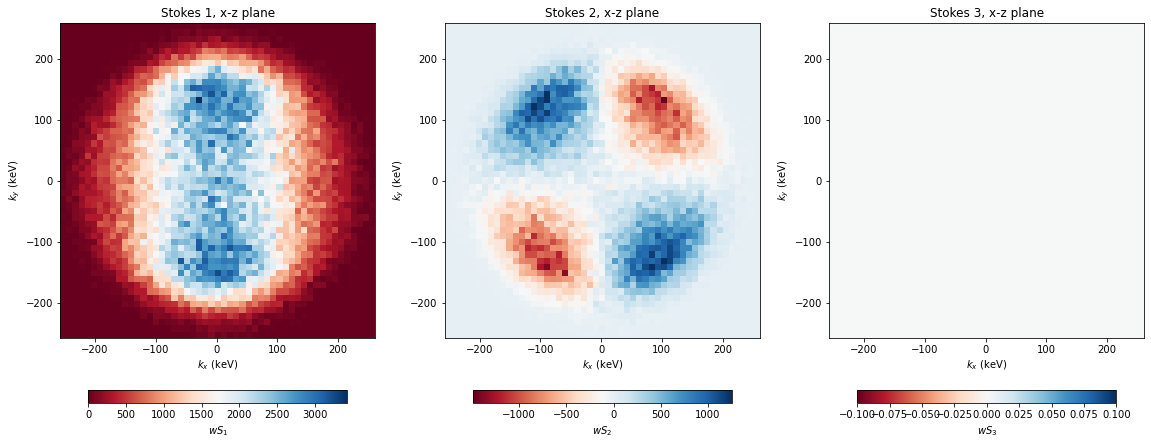

In [10]:
fig,ax = subplots(ncols=3, nrows=1, figsize=(16,6), constrained_layout=True)

for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$k_x$ (keV)')
    axj.set_ylabel(r'$k_y$ (keV)')

    
    
p=ax[0].hist2d(K1*1e6,K2*1e6,bins=(51,51),weights=W*S1,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[0],label=r'$w S_1$', orientation='horizontal', shrink=0.8)

p=ax[1].hist2d(K1*1e6,K2*1e6,bins=(51,51),weights=W*S2,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[1],label=r'$w S_2$', orientation='horizontal', shrink=0.8)

p=ax[2].hist2d(K1*1e6,K2*1e6,bins=(51,51),weights=W*S3,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[2],label=r'$w S_3$', orientation='horizontal', shrink=0.8)


ax[0].set_title('Stokes 1, x-z plane')
ax[1].set_title('Stokes 2, x-z plane')
ax[2].set_title('Stokes 3, x-z plane')


savefig(f'{input_filename}_photon_transverse_momentum_Stokes.pdf', bbox_inches='tight')


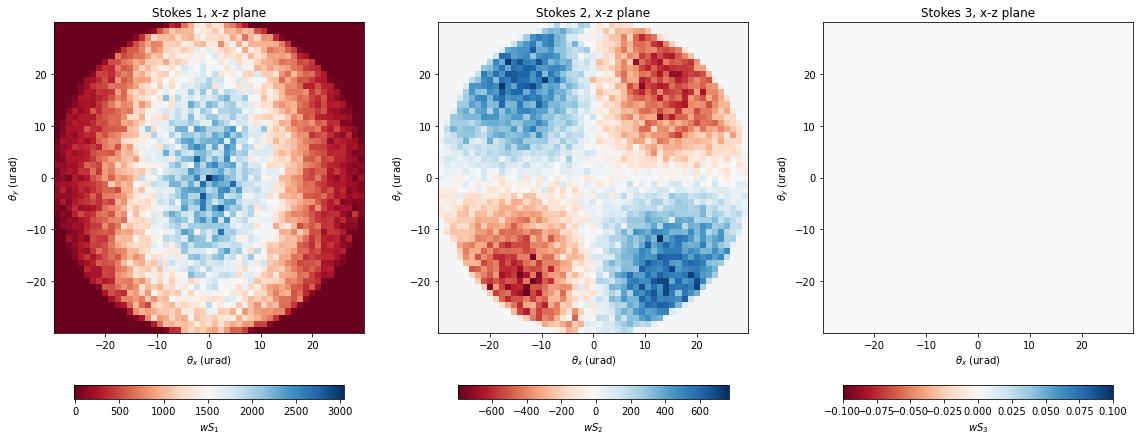

In [11]:
fig,ax = subplots(ncols=3, nrows=1, figsize=(16,6), constrained_layout=True)

for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$\theta_x$ (urad)')
    axj.set_ylabel(r'$\theta_y$ (urad)')

    
    
p=ax[0].hist2d(1e6*K1/K3,1e6*K2/K3,bins=(51,51),weights=W*S1,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[0],label=r'$w S_1$', orientation='horizontal', shrink=0.8)

p=ax[1].hist2d(1e6*K1/K3,1e6*K2/K3,bins=(51,51),weights=W*S2,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[1],label=r'$w S_2$', orientation='horizontal', shrink=0.8)

p=ax[2].hist2d(1e6*K1/K3,1e6*K2/K3,bins=(51,51),weights=W*S3,rasterized=True,cmap=cm.RdBu);
colorbar(p[-1],ax=ax[2],label=r'$w S_3$', orientation='horizontal', shrink=0.8)


ax[0].set_title('Stokes 1, x-z plane')
ax[1].set_title('Stokes 2, x-z plane')
ax[2].set_title('Stokes 3, x-z plane')


savefig(f'{input_filename}_photon_transverse_momentum_Stokes.pdf', bbox_inches='tight')


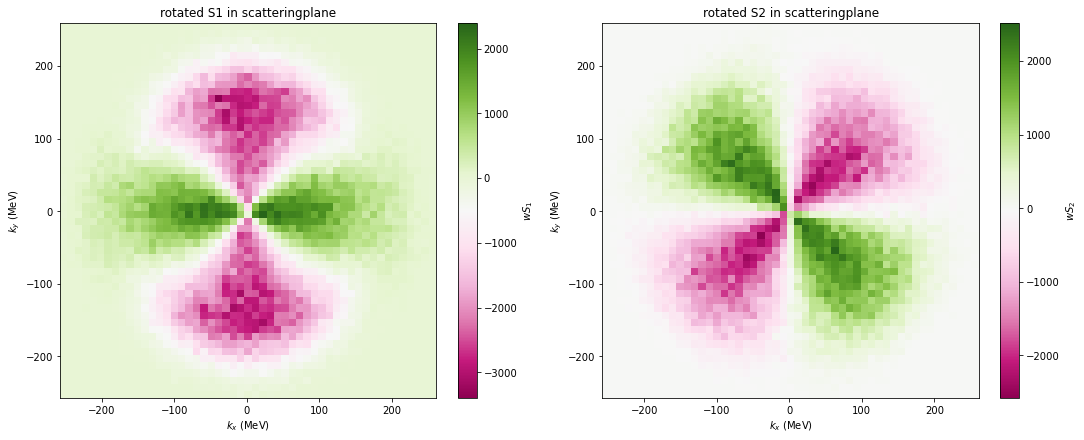

In [12]:
phi         = SIM.phi
# rotated Stokes parameters
Stokes_rot1 = SIM.S1_scatteringplane
Stokes_rot2 = SIM.S2_scatteringplane


fig, ax = subplots(ncols=2,nrows=1,figsize=(15,6), constrained_layout=True)

for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$k_x$ (MeV)' )
    axj.set_ylabel(r'$k_y$ (MeV)' )
    
H1=histogram2d(K1*1e6,K2*1e6,bins=(51,52),weights=W*Stokes_rot1);
p=ax[0].pcolormesh(H1[1],H1[2],H1[0].T,rasterized=True,cmap=cm.PiYG)
plt.colorbar(p,ax=ax[0], label=r'$w S_1$')
ax[0].set_title('rotated S1 in scatteringplane')



H2=histogram2d(K1*1e6,K2*1e6,bins=(51,52),weights=W*Stokes_rot2);
p=ax[1].pcolormesh(H2[1],H2[2],H2[0].T,rasterized=True,cmap=cm.PiYG)
plt.colorbar(p,ax=ax[1], label=r'$w S_2$')
ax[1].set_title('rotated S2 in scatteringplane')

savefig(f'{input_filename}_StokesParameters_scatteringplane_momentum.pdf', bbox_inches='tight')

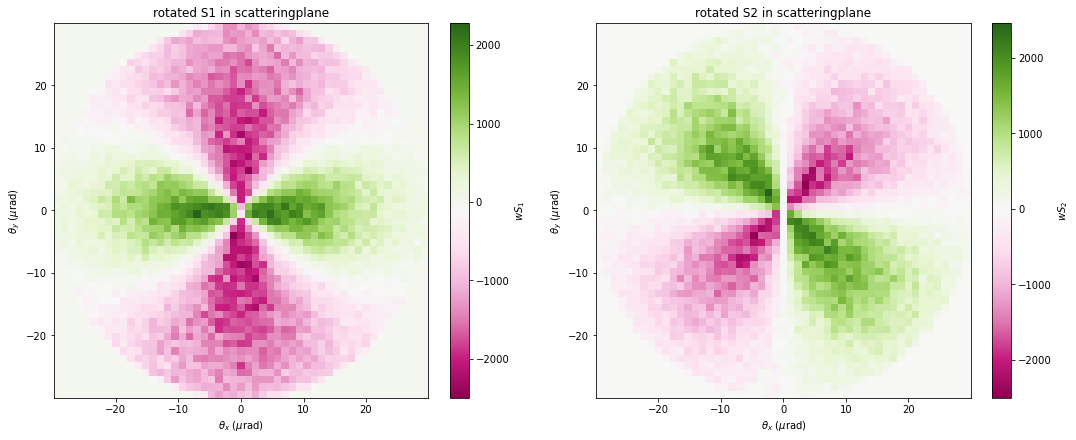

In [13]:
phi         = SIM.phi
# rotated Stokes parameters
Stokes_rot1 = SIM.S1_scatteringplane
Stokes_rot2 = SIM.S2_scatteringplane


fig, ax = subplots(ncols=2,nrows=1,figsize=(15,6), constrained_layout=True)

for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$\theta_x$ ($\mu$rad)' )
    axj.set_ylabel(r'$\theta_y$ ($\mu$rad)' )
    
H1=histogram2d(K1/K3*1e6,K2/K3*1e6,bins=(51,52),weights=W*Stokes_rot1);
p=ax[0].pcolormesh(H1[1],H1[2],H1[0].T,rasterized=True,cmap=cm.PiYG)
plt.colorbar(p,ax=ax[0], label=r'$w S_1$')
ax[0].set_title('rotated S1 in scatteringplane')



H2=histogram2d(K1/K3*1e6,K2/K3*1e6,bins=(51,52),weights=W*Stokes_rot2);
p=ax[1].pcolormesh(H2[1],H2[2],H2[0].T,rasterized=True,cmap=cm.PiYG)
plt.colorbar(p,ax=ax[1], label=r'$w S_2$')
ax[1].set_title('rotated S2 in scatteringplane')

savefig(f'{input_filename}_StokesParameters_scatteringplane_angle.pdf', bbox_inches='tight')

/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1223937178.py:18: RuntimeWarning: invalid value encountered in divide
  mean_PolDegree           = values_w_s / values_w
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1223937178.py:19: RuntimeWarning: invalid value encountered in divide
  mean_Tiltangle           = values_w_tilt / values_w


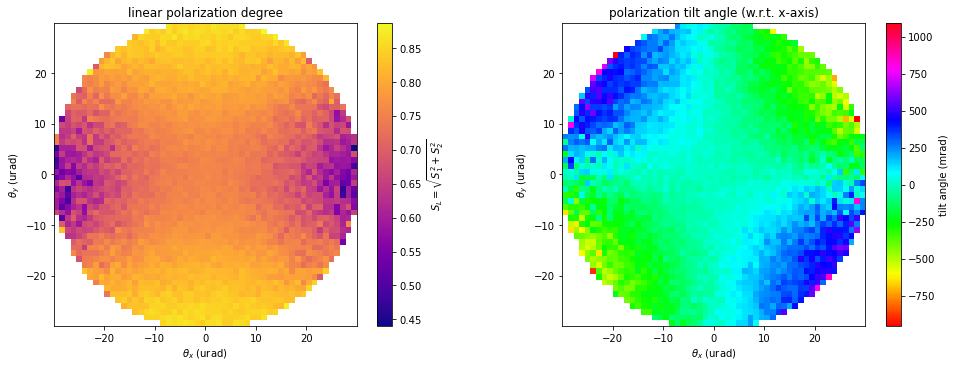

In [14]:
PolDegree = SIM.LinearPolarizationDegree
TiltAngle = 0.5*np.arctan2(S2,S1) 
phi       = SIM.phi



# figure(figsize=(10,6))

bbins = (54,52)

# subplot(111,aspect=1)
values_w_s, xedge, yedge = np.histogram2d(1e6*K1/K3, 1e6*K2/K3, bins=bbins, weights=W*PolDegree )
values_w  , *_           = np.histogram2d(1e6*K1/K3, 1e6*K2/K3, bins=bbins, weights=W           )
values_w_tilt, *_        = np.histogram2d(1e6*K1/K3, 1e6*K2/K3, bins=bbins, weights=W*TiltAngle )

# print (histogram2d(K1/1e6,K2/1e6,bins=(51,51),weights=W*PolDegree))

mean_PolDegree           = values_w_s / values_w
mean_Tiltangle           = values_w_tilt / values_w


fig,ax = subplots(1,2,figsize=(14,5), constrained_layout=True)
p=ax[0].pcolormesh( xedge, yedge, mean_PolDegree.T , rasterized=True, cmap=cm.plasma);
colorbar(p,ax=ax[0], label='$S_L=\sqrt{S_1^2+S_2^2}$')

p=ax[1].pcolormesh( xedge, yedge, 1000*mean_Tiltangle.T ,rasterized=True, cmap=cm.hsv);
colorbar(p,ax=ax[1], label='tilt angle (mrad)')


for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$\theta_x$ (urad)')
    axj.set_ylabel(r'$\theta_y$ (urad)')

ax[0].set_title(r'linear polarization degree')
ax[1].set_title(r'polarization tilt angle (w.r.t. x-axis)')

savefig(f'{input_filename}_polarization_state_angles.pdf', bbox_inches='tight')


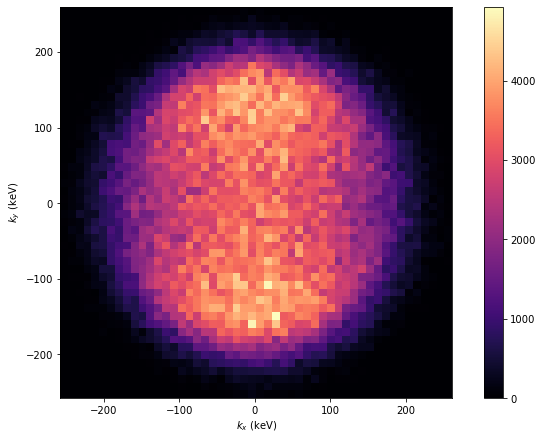

In [15]:
figure(figsize=(10,6), constrained_layout=True)

subplot(111,aspect=1)
hist2d(K1*1e6,K2*1e6,bins=(50,50),weights=W,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$k_x$ (keV)')
ylabel(r'$k_y$ (keV)')


savefig(f'{input_filename}_photon_transverse_momentum.pdf', bbox_inches='tight')

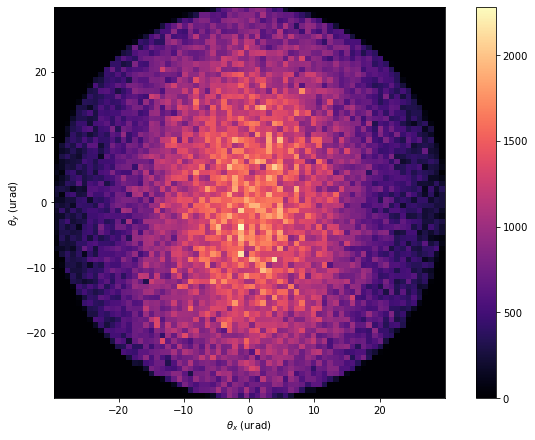

In [16]:
figure(figsize=(10,6), constrained_layout=True)

subplot(111,aspect=1)
hist2d(K1/K3*1e6,K2/K3*1e6,bins=(70,72),weights=W,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$\theta_x$ (urad)')
ylabel(r'$\theta_y$ (urad)')


savefig(f'{input_filename}_photon_transverse_angles.pdf', bbox_inches='tight')

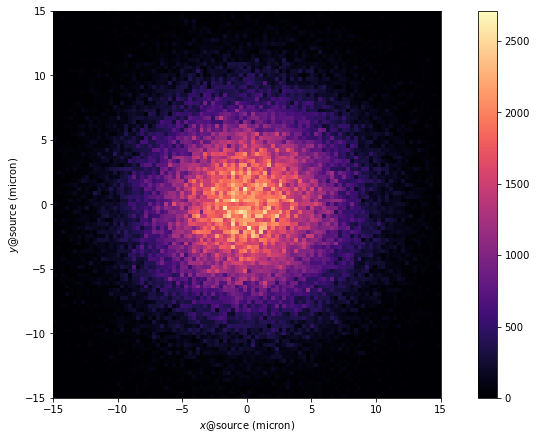

In [17]:
figure(figsize=(10,6), constrained_layout=True)

bbins=(linspace(-3*sigmaX,3*sigmaX,99),linspace(-3*sigmaY,3*sigmaY,100))

subplot(111,aspect=1)
hist2d(X1,X2,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$x@$source (micron)')
ylabel(r'$y@$source (micron)')

# xlim(-2*w0,2*w0)
# ylim(-2*w0,2*w0)

# xlim(-2*sigmaX,2*sigmaX)
# ylim(-2*sigmaY,2*sigmaY)



savefig(f'{input_filename}_photon_source_size.pdf', bbox_inches='tight')


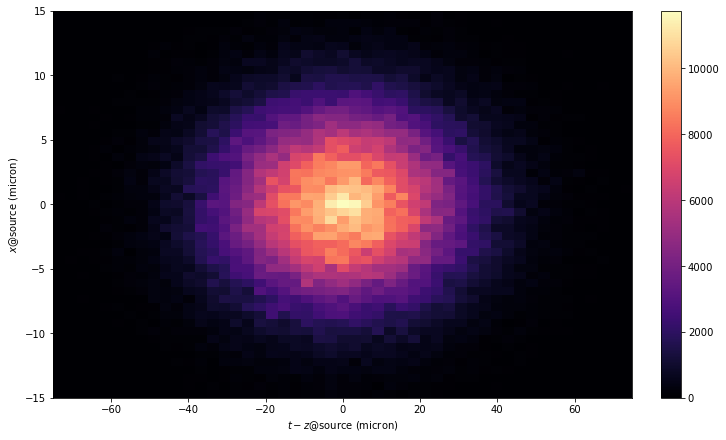

In [18]:
figure(figsize=(10,6), constrained_layout=True)
bbins=(linspace(-75,75,50),linspace(-3*sigmaX,3*sigmaX,50))

subplot(111)
hist2d(X0-X3,X1,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$x@$source (micron)')



savefig(f'{input_filename}_photon_source_length.pdf', bbox_inches='tight')


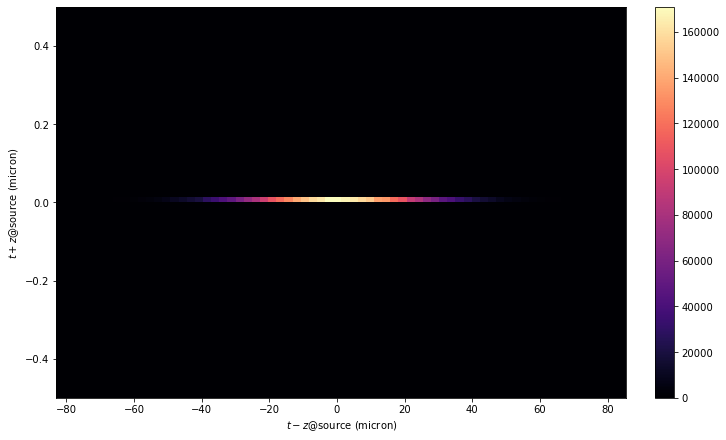

In [19]:
figure(figsize=(10,6), constrained_layout=True)
bbins=(70,72)

subplot(111)
hist2d(X0-X3,X0+X3,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$t+z@$source (micron)')



savefig(f'{input_filename}_photon_source_lightfront.pdf', bbox_inches='tight')


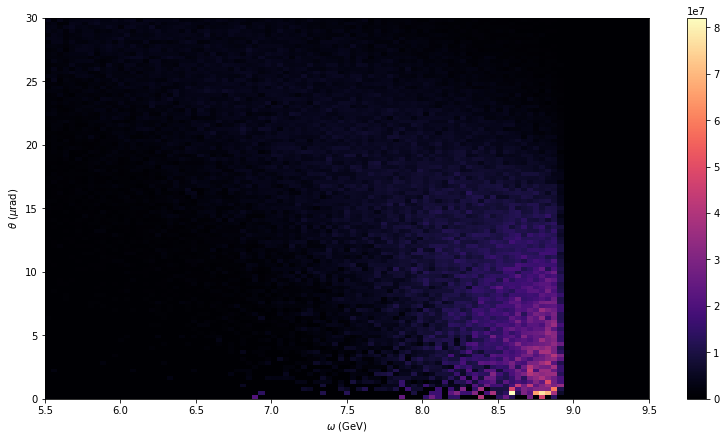

In [20]:
figure(figsize=(10,6), constrained_layout=True)

bbins=(linspace(omegamin,omegamax,100),linspace(thetamin,thetamax,102))

subplot(111)
hist2d(K0,sqrt(K1**2+K2**2)/K3*1e6,bins=bbins,weights=W/sqrt(K1**2+K2**2),rasterized=True,cmap=cm.magma);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ ($\mu$rad)');


savefig(f'{input_filename}_photon_angular_spectrum.pdf', bbox_inches='tight')


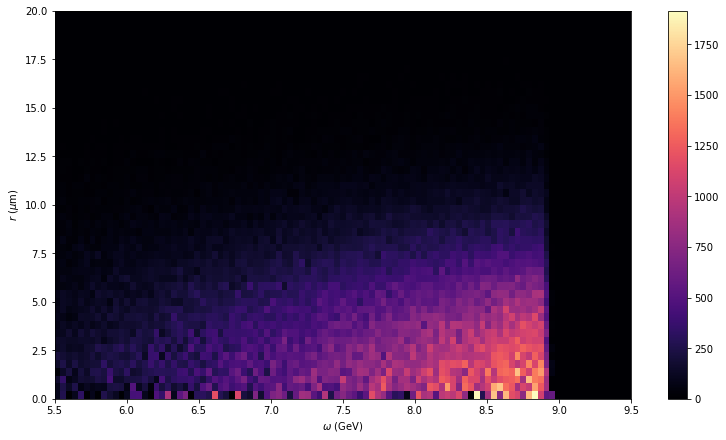

In [21]:
figure(figsize=(10,6), constrained_layout=True)

bbins=(linspace(omegamin,omegamax,100),linspace(0,4*sigmaX,51))

subplot(111)
hist2d(K0,sqrt(X1**2+X2**2),bins=bbins,weights=W/sqrt(X1**2+X2**2),rasterized=True,cmap=cm.magma);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$r$ ($\mu$m)');
ylim(0,4*sigmaX)

savefig(f'{input_filename}_photon_transverse_spectrum.pdf', bbox_inches='tight')


In [22]:
xoffset = SIM.xoffset
yoffset = SIM.yoffset


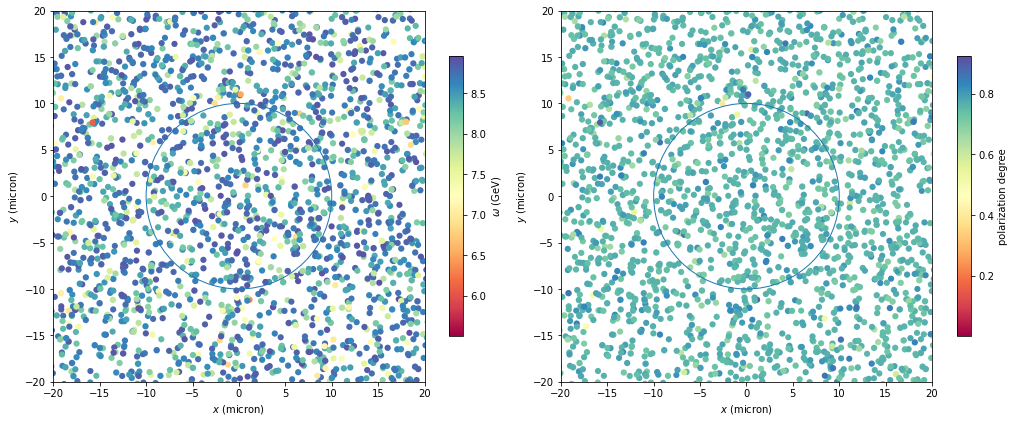

In [23]:
spotsize = 10 # micron


figure(figsize=(14,6), constrained_layout=True)

ax1=subplot(121,aspect=1)
scatter(X1+xoffset, X2+yoffset, c=K0, marker='.', lw=0, s=5*W, cmap=cm.Spectral);
colorbar(label='$\omega$ (GeV)', shrink=0.7)
xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
# title('zero source size')


ax2=subplot(122,aspect=1)

scatter(X1+xoffset, X2+yoffset, c=SIM.LinearPolarizationDegree, marker='.', lw=0, s=5*W, cmap=cm.Spectral);
colorbar(label=r'polarization degree', shrink=0.7)
xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)

xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
# title('finite source size')

ax1.add_patch(Circle((0,0),spotsize,color='C0',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='C0',fill=False))


savefig(f'{input_filename}_photons_at_focus.png',dpi=200, bbox_inches='tight')



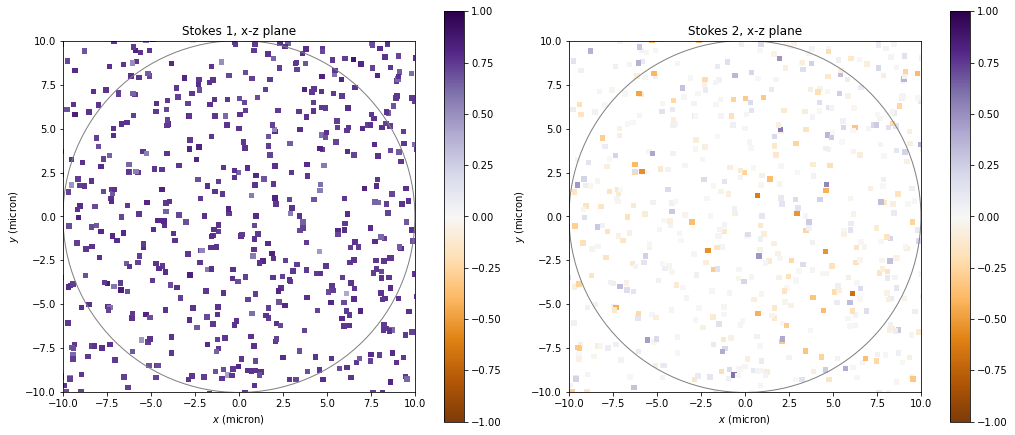

In [24]:
spotsize = 10 # micron


figure(figsize=(14,6), constrained_layout=True)

ax1=subplot(121,aspect=1)
scatter(X1+xoffset, X2+yoffset, c=S1, marker='s',lw=0,s=30,vmin=-1,vmax=1,cmap=cm.PuOr);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Stokes 1, x-z plane')


ax2=subplot(122,aspect=1)

scatter(X1+xoffset, X2+yoffset, c=S2, marker='s',lw=0,s=30,vmin=-1,vmax=1,cmap=cm.PuOr);
colorbar()

xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)

xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Stokes 2, x-z plane')

ax1.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))


# suptitle(f'{sampling} sampling')

savefig(f'{input_filename}_photons_at_focus_StokesParameters.png',dpi=200, bbox_inches='tight')



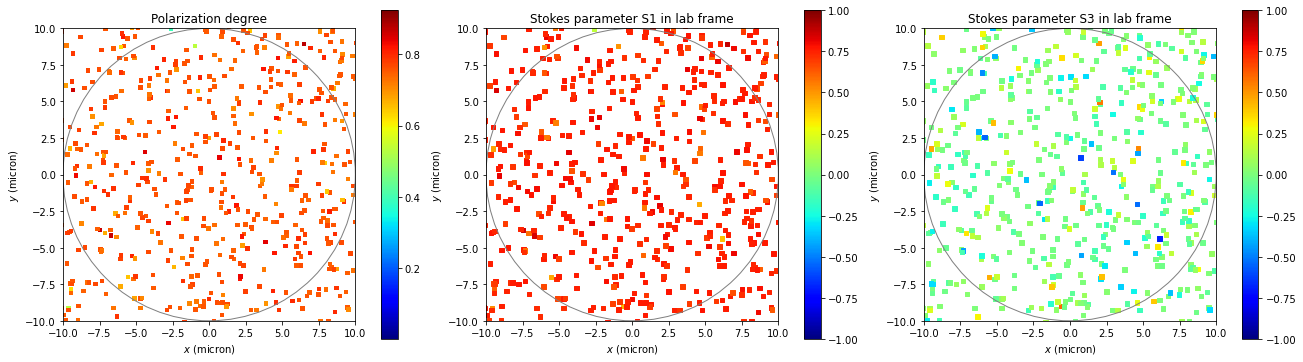

In [25]:
spotsize = 10 # micron


figure(figsize=(18,5), constrained_layout=True)

ax1=subplot(131,aspect=1)
scatter(X1+xoffset, X2+yoffset, c=sqrt(S1**2 + S2**2), marker='s',lw=0,s=20,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Polarization degree')


ax2=subplot(132,aspect=1)

title('Stokes parameter S1 in lab frame')

scatter(X1+xoffset, X2+yoffset, c=S1, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');

ax3=subplot(133,aspect=1)

title('Stokes parameter S3 in lab frame')

scatter(X1+xoffset, X2+yoffset, c=S2, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');

ax1.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax3.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))


# suptitle(f'{sampling} sampling')

savefig(f'{input_filename}_PolarizationDegree2.png',dpi=200, bbox_inches='tight')



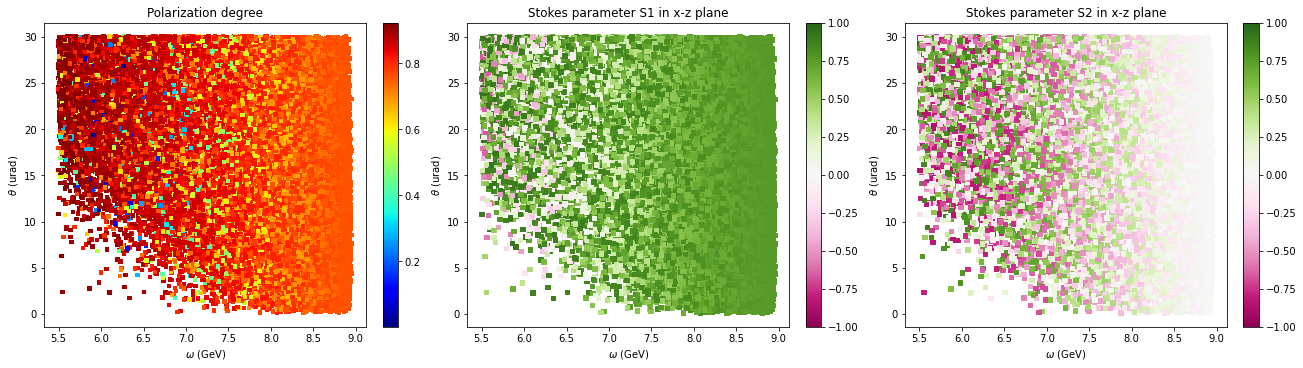

In [26]:
spotsize = 10 # micron

figure(figsize=(18,5), constrained_layout=True)

ax1=subplot(131)
scatter(K0, 1e6* sqrt(K1**2+K2**2)/K3, c=sqrt(S1**2 + S2**2), marker='s',lw=0,s=20,cmap=cm.jet);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('Polarization degree')


ax2=subplot(132)

title('Stokes parameter S1 in x-z plane')

scatter(K0,  1e6*sqrt(K1**2+K2**2)/K3, c=S1, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('Stokes parameter S2 in x-z plane')

scatter(K0,  1e6*sqrt(K1**2+K2**2)/K3, c=S2, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'{input_filename}_PolarizationDegree_energyangle_scatter.png',dpi=200, bbox_inches='tight')



/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/3858126729.py:20: RuntimeWarning: invalid value encountered in divide
  pcolormesh(xedge, yedge , (values_w_s / values_w ).T, rasterized=True , cmap=cm.jet, vmin=0,vmax=1);
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/3858126729.py:30: RuntimeWarning: invalid value encountered in divide
  pcolormesh(xedge, yedge, (values_w_S1/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/3858126729.py:40: RuntimeWarning: invalid value encountered in divide
  pcolormesh(xedge, yedge, (values_w_S2/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);


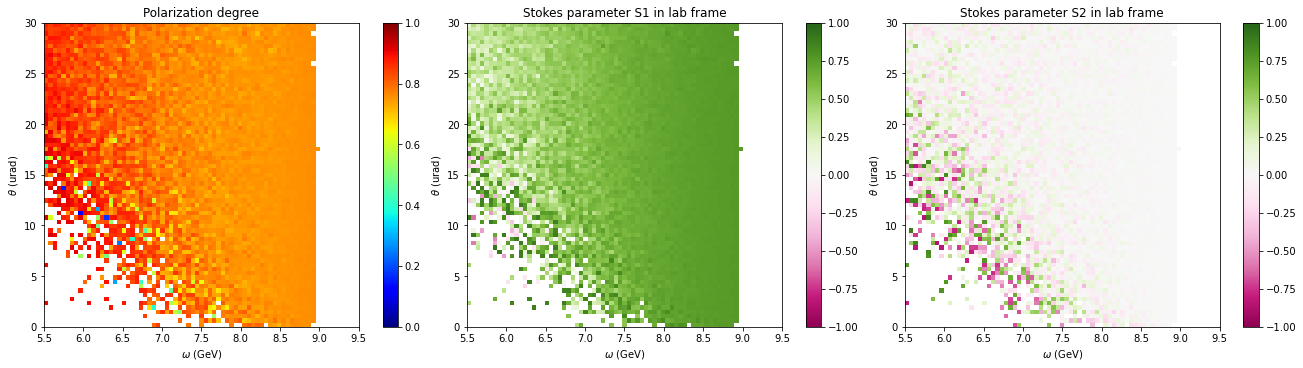

In [27]:
spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
PolDegree   = SIM.LinearPolarizationDegree

bbins = (linspace(omegamin,omegamax,74),linspace(thetamin,thetamax,72))

# subplot(111,aspect=1)
values_w_s, xedge, yedge = np.histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree )
values_w  , *_           = np.histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W           )
values_w_S1,*_           = np.histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S1 )
values_w_S2, *_          = np.histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S2 )



figure(figsize=(18,5), constrained_layout=True)

ax1=subplot(131)
pcolormesh(xedge, yedge , (values_w_s / values_w ).T, rasterized=True , cmap=cm.jet, vmin=0,vmax=1);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('Polarization degree')


ax2=subplot(132)
title('Stokes parameter S1 in lab frame')

pcolormesh(xedge, yedge, (values_w_S1/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('Stokes parameter S2 in lab frame')

pcolormesh(xedge, yedge, (values_w_S2/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'{input_filename}_PolarizationDegree_energyangle_histogram.pdf',dpi=200, bbox_inches='tight')



/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:17: RuntimeWarning: invalid value encountered in divide
  mean_poldegree = values_w_s/values_w
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:18: RuntimeWarning: invalid value encountered in divide
  mean_S1      = values_w_S1/values_w
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:19: RuntimeWarning: invalid value encountered in divide
  mean_S2      = values_w_S2/values_w
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:25: RuntimeWarning: invalid value encountered in divide
  var_s  = values_moment2_w_s    / values_w - mean_poldegree**2
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:26: RuntimeWarning: invalid value encountered in divide
  var_S1 = values_moment2_w_S1 / values_w - mean_S1**2
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_39901/1673901521.py:27: RuntimeW

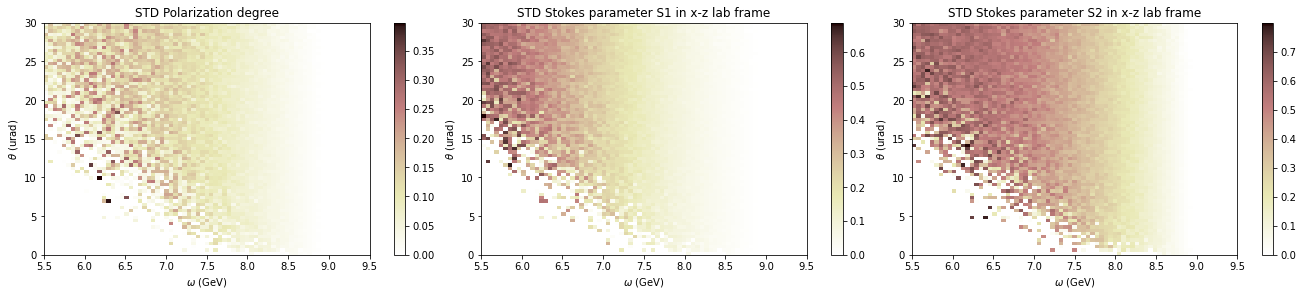

In [28]:
# standard deviations

spotsize = 10 # micron

phi         = SIM.phi
# rotated Stokes parameters
PolDegree   = SIM.LinearPolarizationDegree

bbins = (linspace(omegamin,omegamax,74),linspace(thetamin,thetamax,72))

# subplot(111,aspect=1)
values_w_s, xedge, yedge  = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree )
values_w  , xedge, yedge  = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W           )
values_w_S1, xedge, yedge = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S1 )
values_w_S2, xedge, yedge = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S2 )

mean_poldegree = values_w_s/values_w
mean_S1      = values_w_S1/values_w
mean_S2      = values_w_S2/values_w

values_moment2_w_s, *_    = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree**2 )
values_moment2_w_S1, *_ = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S1**2 )
values_moment2_w_S2, *_ = histogram2d(K0,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*S2**2 )

var_s  = values_moment2_w_s    / values_w - mean_poldegree**2
var_S1 = values_moment2_w_S1 / values_w - mean_S1**2
var_S2 = values_moment2_w_S2 / values_w - mean_S2**2

std_s  = sqrt(var_s)
std_S1 = sqrt(var_S1)
std_S2 = sqrt(var_S2)


figure(figsize=(18,4), constrained_layout=True)

ax1=subplot(131)
pcolormesh(xedge, yedge , std_s.T, rasterized=True , cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('STD Polarization degree')


ax2=subplot(132)
title('STD Stokes parameter S1 in x-z lab frame')

pcolormesh(xedge, yedge, std_S1.T, rasterized=True,cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('STD Stokes parameter S2 in x-z lab frame')

pcolormesh(xedge, yedge, std_S2.T, rasterized=True,cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'{input_filename}_PolarizationDegree_STD.pdf',dpi=200, bbox_inches='tight')



In [29]:
# selector1 = sqrt(xoffset**2+yoffset**2) < spotsize
selector2 = sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize

print ( f'IP-laser spot size                : {spotsize:.2f} micron')
# print ( f'baseline          : {baseline/1e6:.2f} metres')
print ('-'*82)
print ( input_filename)

print (f'min macrophoton weight              : {amin(W):.6g}')
print (f'max macrophoton weight              : {amax(W):.6g}')
# print ( 'macrophotons, zero   source size :',sum( selector1 ) )
print (f'macrophotons in spot                : {sum( selector2 ):.0f}' )
# print ( 'photon weight, zero   source size:',sum(W[selector1 ] ) )
print (f'total photon weight in spot         : {sum(W[selector2 ]):.1f}' )

print (f'photon density                      : {sum(W[selector2 ] ) /(np.pi*spotsize**2):.4f} photons/micron^2')


print (f'average polarization degree in spot : {average(SIM.LinearPolarizationDegree[selector2], weights=W[selector2]):.4f}' )

print (f'total pulse energy                  : {SIM.total_energy_J*100:.4f} mJ' )


IP-laser spot size                : 10.00 micron
----------------------------------------------------------------------------------
./examples/testbeam2
min macrophoton weight              : 30.2665
max macrophoton weight              : 33.4094
macrophotons in spot                : 422
total photon weight in spot         : 13432.3
photon density                      : 42.7563 photons/micron^2
average polarization degree in spot : 0.7565
total pulse energy                  : 62276.8177 mJ


### Photon Spectrum at IP

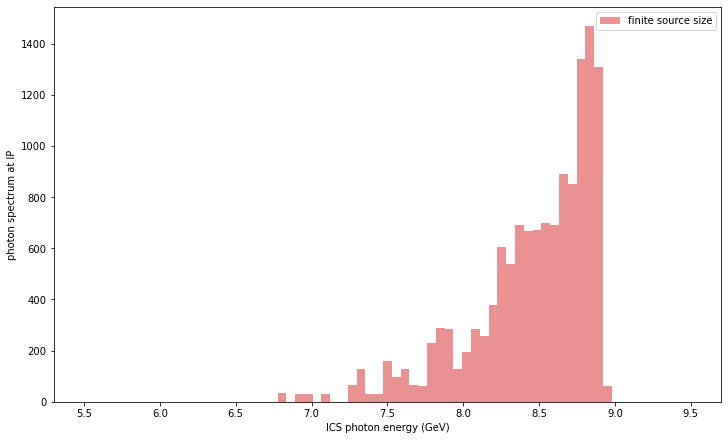

In [30]:
figure(figsize=(10,6), constrained_layout=True)

subplot(111)
# hist(K0[selector1],bins=linspace(omegamin,omegamax,70),weights=W[selector1],alpha=1  ,fc='C0',label='no source size');
hist(K0[selector2],bins=linspace(omegamin,omegamax,70),weights=W[selector2],alpha=0.5,fc='C3',label='finite source size'); 
# xlim(6,9)
legend()
xlabel('ICS photon energy (GeV)')
ylabel('photon spectrum at IP')

savefig(f'{input_filename}_photon_spectrum_at_focus.pdf', bbox_inches='tight')


### Photon Weight Distribution at IP

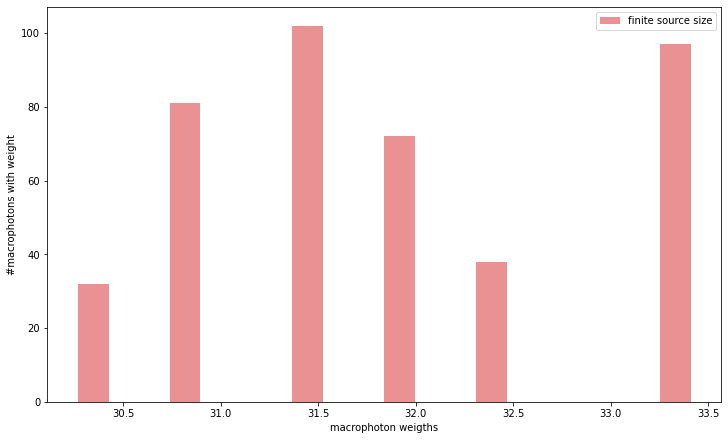

In [31]:
figure(figsize=(10,6), constrained_layout=True)
base_weight = amax(W)
bbins = 20#linspace(50) 

# hist( W[selector1],bins=bbins,label='zero source size'  ,fc='C0');
hist( W[selector2],bins=bbins,label='finite source size',fc='C3',alpha=0.5);


xlabel('macrophoton weigths')
ylabel('#macrophotons with weight')
legend()
savefig(f'{input_filename}_photon_weights.pdf', bbox_inches='tight')


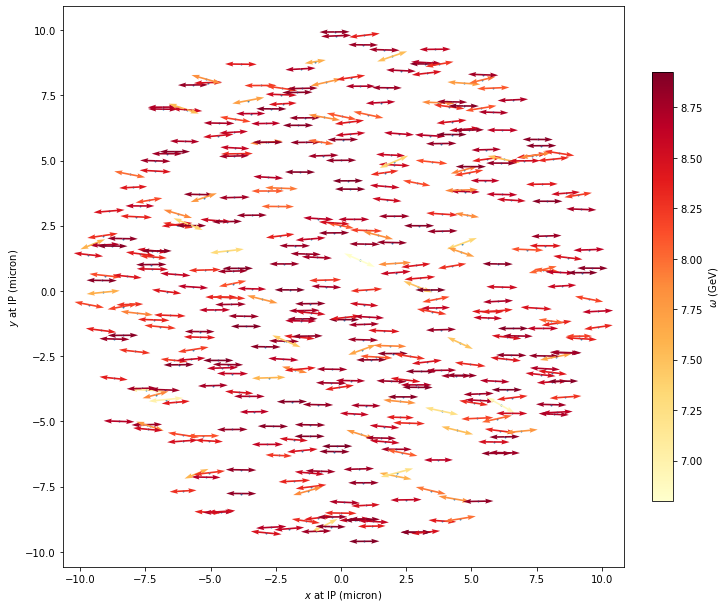

In [32]:
figure(figsize=(10,10), constrained_layout=True)
subplot(aspect=1)

xfoc = (X1+xoffset)[selector2]
yfoc = (X2+yoffset)[selector2]

TA   = 0.5*np.arctan2(S2,S1) 

scale = 2

xpol = scale * SIM.LinearPolarizationDegree[selector2] * np.cos(TA[selector2])
ypol = scale * SIM.LinearPolarizationDegree[selector2] * np.sin(TA[selector2])

scatter(xfoc,yfoc, s=1)

# quiver([X, Y], U, V, [C], **kwargs)

p = quiver(xfoc,yfoc, xpol , ypol  , K0[selector2] , cmap=cm.YlOrRd )  
quiver(xfoc,yfoc, -xpol , -ypol , K0[selector2] , cmap=cm.YlOrRd )
plt.colorbar(p, shrink=0.6, label=r'$\omega$ (GeV)')

xlabel(r'$x$ at IP (micron)')
ylabel(r'$y$ at IP (micron)')

savefig(f'{input_filename}_Polarization_at_IP_focus.pdf', bbox_inches='tight')

92


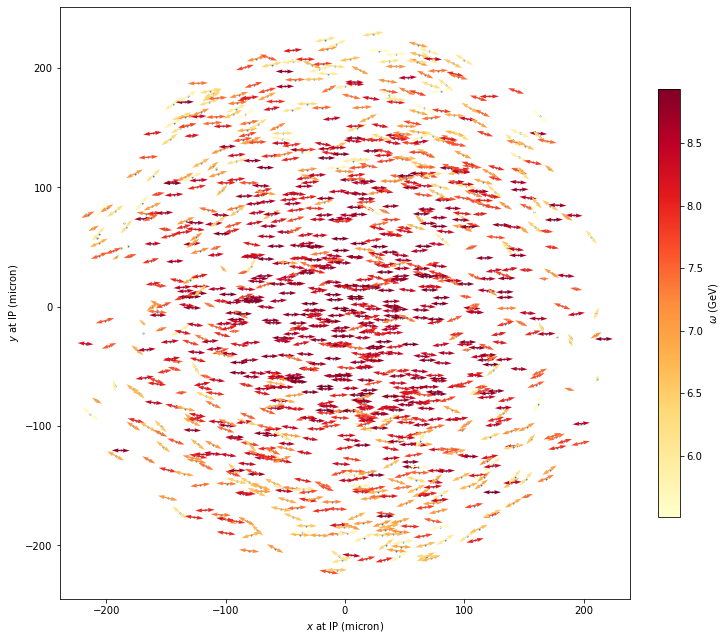

In [33]:
figure(figsize=(10,10), constrained_layout=True)
subplot(aspect=1)

subs = int(len(xoffset)/1200)
print (subs)

xfoc = (X1+xoffset)[::subs]
yfoc = (X2+yoffset)[::subs]

TA   = 0.5*np.arctan2(S2,S1) 

scale = 2

xpol = scale * (SIM.LinearPolarizationDegree * np.cos(TA))[::subs]
ypol = scale * (SIM.LinearPolarizationDegree * np.sin(TA))[::subs]

scatter(xfoc,yfoc, s=1)

# quiver([X, Y], U, V, [C], **kwargs)

p = quiver(xfoc,yfoc, xpol , ypol  , K0[::subs] , cmap=cm.YlOrRd )  
quiver(xfoc,yfoc, -xpol , -ypol , K0[::subs] , cmap=cm.YlOrRd )
plt.colorbar(p, shrink=0.6, label=r'$\omega$ (GeV)')

xlabel(r'$x$ at IP (micron)')
ylabel(r'$y$ at IP (micron)')

savefig(f'{input_filename}_Polarization_at_IP_focus_large.pdf', bbox_inches='tight')

# Electrons

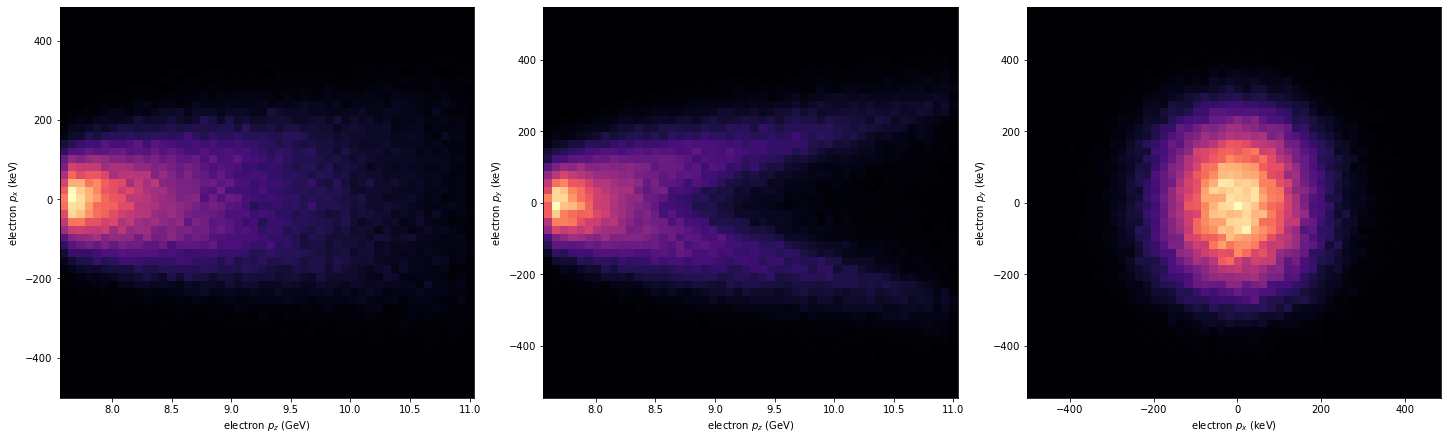

In [34]:
fig,ax=subplots(1,3,figsize=(20,6), constrained_layout=True)
bbins=(50,50)

p0=ax[0].hist2d(P3,P1*1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p0,ax=ax[0])

p1=ax[1].hist2d(P3,P2*1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p1,ax=ax[1])

p2=ax[2].hist2d(P1*1e6,P2*1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p2,ax=ax[2])


ax[0].set_xlabel(r'electron $p_z$ (GeV)')
ax[1].set_xlabel(r'electron $p_z$ (GeV)')
ax[2].set_xlabel(r'electron $p_x$ (keV)')

ax[0].set_ylabel(r'electron $p_x$ (keV)')
ax[1].set_ylabel(r'electron $p_y$ (keV)')
ax[2].set_ylabel(r'electron $p_y$ (keV)')


savefig(f'{input_filename}_electrons_final_momentum.pdf', bbox_inches='tight')


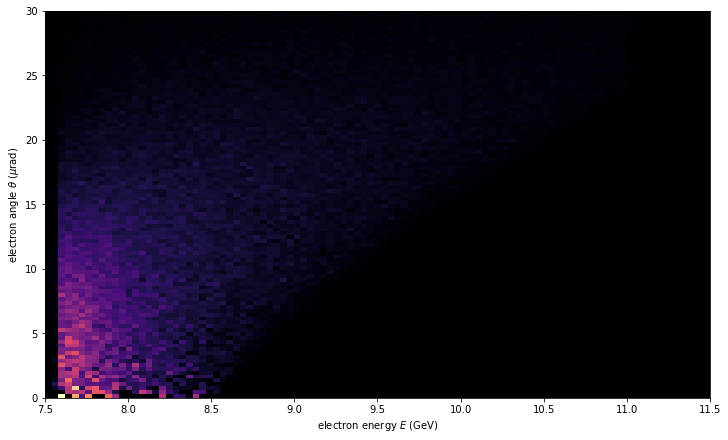

In [35]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(linspace(7.5,11.5,100),linspace(0,30,101))

fig,ax=subplots(1,1,figsize=(10,6), constrained_layout=True)

hist2d( P0 , theta_e*1e6 , bins=bbins , weights=W/theta_e, cmap=cm.magma, rasterized=True );

xlabel(r'electron energy $E$ (GeV)')
ylabel(r'electron angle $\theta$ ($\mu$rad)');

savefig(f'{input_filename}_electrons_final_energy_angle.pdf', bbox_inches='tight')


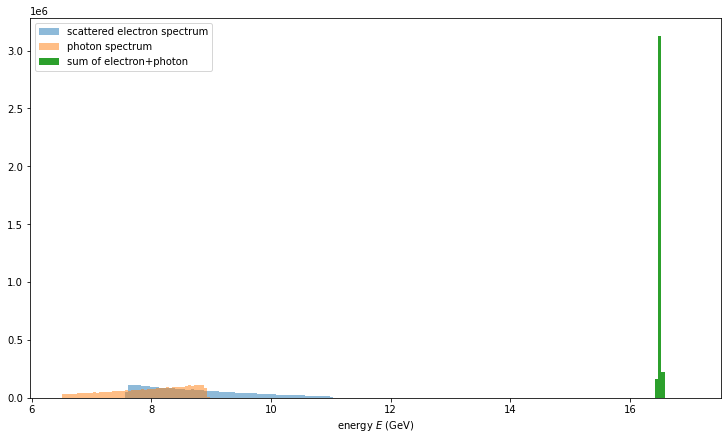

In [36]:
fig,ax=subplots(1,1,figsize=(10,6), constrained_layout=True)

bbins=linspace(6.5,17,200)

p0=ax.hist(P0,bins=bbins,weights=W, alpha=0.5, label='scattered electron spectrum', rasterized=True);
p0=ax.hist(K0,bins=bbins,weights=W, alpha=0.5, label='photon spectrum' , rasterized=True);

ax.hist(P0+K0, bins=bbins, weights=W, label='sum of electron+photon', rasterized=True)


# p0=ax.hist(P0/1e9,bins=70,weights=W,alpha=0.5);
xlabel(r'energy $E$ (GeV)')
legend(loc='best')
# xlim(6,17)

savefig(f'{input_filename}_electrons_final_energy.pdf', bbox_inches='tight')


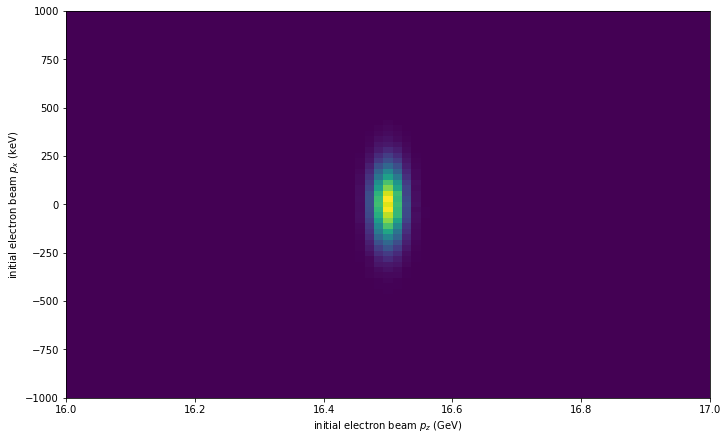

In [37]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

# bbins=(70,71)
bbins = (linspace(16,17,70),linspace(-1000,1000,72))

fig,ax=subplots(1,1,figsize=(10,6), constrained_layout=True)

hist2d( (P3+K3) , (P1+K1)*1e6 , bins=bbins , rasterized=True );
xlabel(r'initial electron beam $p_z$ (GeV)')
ylabel(r'initial electron beam $p_x$ (keV)')

savefig(f'{input_filename}_electrons_initial_beam.pdf', bbox_inches='tight')


